In [105]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Running on",device)

Running on cpu


In [2]:
dat = np.genfromtxt("mnist_train.csv", delimiter = ",", skip_header = 1)

In [145]:
X, y = dat[:,1:]/255.0, dat[:,0]

X = torch.tensor(X, requires_grad=True, dtype = torch.double).view(-1,28,28).unsqueeze(1)

y = torch.tensor(y, requires_grad=False, dtype = int)

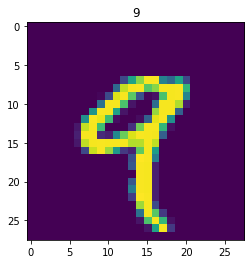

In [148]:
i = 4
plt.imshow(X[i].detach().numpy()[0])
plt.title(str(y[i].numpy()))
plt.show()

In [129]:
# def onehot(y):
#     out = torch.zeros(y.shape[0],10)
#     for i in range(y.shape[0]):
#         out[i][y[i]] = 1
#     return out

def batch_loader(X,y, batch_size = 6):
    for i in range(y.shape[0]//batch_size):
        X_out = X[i*batch_size:(i+1)*batch_size]

        y_out = y[i*batch_size:(i+1)*batch_size]

        # y_out = onehot(y_out)
        
        yield X_out, y_out

In [152]:
class CNN(nn.Module):
    def __init__(self,SIZE = 100):
        super (CNN, self).__init__()

        self.SIZE = SIZE

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2))
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=SIZE, kernel_size=(5, 5))
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.linear1 = nn.Linear(in_features=SIZE*4*4, out_features=SIZE*4*4//2)
        self.activation3 = nn.ReLU()

        self.linear2 = nn.Linear(in_features=SIZE*4*4//2, out_features=10)
        # self.final_activation = nn.Softmax(dim=0)
        self.final_activation = lambda x: x

    def forward(self, x):
        x = self.activation1(self.conv1(x))
        x = self.maxpool1(x)

        x = self.activation2(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1,self.SIZE*4*4)
        x = self.activation3(self.linear1(x))
        x = self.linear2(x)

        out = self.final_activation(x)

        return out


In [171]:
model = CNN(100)

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

batch_size = 32

def train(n_epochs):
    model.train()

    for i in range(n_epochs):
        Loader = batch_loader(X,y, batch_size)

        c = 0
        epoch_loss = 0
        epoch_acc = 0

        pbar = tqdm(Loader, total = y.shape[0]//batch_size)
        for dat, label in pbar:
            pred = model(dat.float())

            loss = loss_fn(pred, label)

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            epoch_acc += (label == pred.argmax(axis = 1)).float().mean()
            c += 1

            if c%10 == 0:
                pbar.set_description(f"loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")
            # if c%100 == 0:
                # print(pred[:5],label[:5],pred[:5].argmax(axis = 1) == label[:5])
        print(f"Epoch {i}/{n_epochs} - loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")


In [172]:
train(10)

  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 